# P1
Written by Babak Hosseini Parsa Ahmadi 810101609, Mohtasham 810101408 and Mahdy Naeini 810101536\
Data science project abou digikala mobile phones.

In [114]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import numpy  as np
import seaborn as sns
import datetime
import time
import re

# Scraping DigiKala

In [2]:
SUB_FEATURES = {"مدل": "Model", "زمان معرفی": "Release Data","وزن": "Weight", "ابعاد": "Dimensions", "برند": "Brand","فروشنده":"Seller",
                "توضیحات سیم کارت":"Sim Card Description", "نوع سیم کارت":"Sim Card Type", "ساختار بدنه":"Body Structure",
                "ویژگی‌های کلیدی": "Key Features", "پردازنده‌ مرکزی": "CPU", "فرکانس پردازنده‌ مرکزی":"CPU Clock Rate","زمان عضویت در emalls":"Intime Emalls",
                "پردازنده‌ گرافیکی":"GPU","توضیحات کارت حافظه جانبی":"SD Card Description","بازه‌ اندازه صفحه نمایش":"Range of Screen Size",
                "نسبت تصویر":"DAR","سایر قابلیت‌ها":"Other Screen Features","موقعیت نما ( GPS )":"GPS","نوع Wi-Fi (ورژن)":"Wi-Fi Type",
                "بلوتوث":"Bluetooth","نسخه بلوتوث":"Bluetooth Version","درگاه‌های ارتباطی":"Ports","رزولوشن عکس":"Camera Resolution",
                "فناوری فوکوس":"Focus Technology","فلش":"Flashlight","قابلیت‌های دوربین":"Camera Features","فیلمبرداری":"Video Recording",
                "خروجی صدا":"Audio Output","سیستم عامل":"OS","نسخه سیستم عامل":"OS Version","حس‌گرها":"Sensors","ویژه در emalls":"Is Special Emalls",
                "مشخصات باتری": "Battery Spec","اقلام همراه":"Accessories","سایر توضیحات اقلام همراه":"Accessories Description",
                "دسته ‌بندی": "Category", "تراشه":"Chipset","حافظه داخلی":"Internal Memory","مقدار RAM":"RAM","گارانتی":"Warranty",
                "پشتیبانی از کارت حافظه": "SD Card Support", "فناوری صفحه‌ نمایش": "Display Technology", "قیمت نهایی": "Price Final",
                "اندازه":"Screen Size","رزولوشن صفحه نمایش":"Screen Resolution","تراکم پیکسلی":"Pixel Density","توضیحات تکمیلی صدا":"Supplementary Audio Description",
                "نسبت صفحه‌ نمایش به بدنه": "Ratio of Screen Size to Body", "شبکه‌های ارتباطی": "Cellular Network","پرداخب قسطی":"Installment",
                "شبکه‌های مخابراتی و ارتباطی قابل پشتیبانی":"Supported Networks","دوربین‌های پشت گوشی":"Back Facing Cameras",
                "دوربین سلفی": "Front Facing Cameras", "رنگ های موجود": "Available Colors", "قیمت بدون تخفیف": "Price No Discount",
                "ویژگی‌های خاص": "Special Features","تعداد سیم کارت":"Number of Sim Cards","امتیاز خریداران":"Score","شهر":"City"}

In [3]:
def make_new_csv(file_addr):
    with open(file_addr, mode='w') as mobiles_file:
        mobilesCSV = csv.writer(mobiles_file)
        mobilesCSV.writerow(list(SUB_FEATURES.values()))

In [4]:
class PHONENOTAVAILABLE(NoSuchElementException):
    pass

In [5]:
def DK_extract_specs(driver):
    spec_button = None
    spec_more_button = None
    while True:
        try:
            driver.execute_script(
                'window.scrollTo(0, document.body.scrollHeight);')
            sleep(1)
            driver.execute_script(
                'window.scrollTo(0, -document.body.scrollHeight);')
            spec_button = driver.find_element(By.ID, "specification").find_elements(
                By.XPATH, "./..")
            sleep(1)
            driver.execute_script(
                "arguments[0].scrollIntoView();", spec_button[0])
            sleep(1)
            spec_more_button = spec_button[0].find_elements(
                By.TAG_NAME, "span")
            spec_more_button[-2].click()
            sleep(1)
            break
        except (NoSuchElementException, ElementClickInterceptedException):
            continue
    page = driver.page_source
    soup = bs(page, 'html.parser')

    global SUB_FEATURES
    scraped_sub_features = dict()
    features_div = soup.find(string="مشخصات کلی").parent.parent.parent
    for fa_feature, eng_feature in (SUB_FEATURES.items()):
        if features_div.find(string=fa_feature):
            found = features_div.find(
                string=fa_feature).parent.parent.findAll('p')[1:]
            scraped_sub_features[eng_feature] = "\r\n".join(
                [s.text for s in found])
        else:
            scraped_sub_features[eng_feature] = ""

    score = soup.findAll("p", {"class": "mr-1 text-body-2"})
    if score:
        scraped_sub_features["Score"] = score[0].text

    brand = soup.findAll("a", {"data-cro-id": "pdp-breadcrumb-down"})
    scraped_sub_features["Brand"] = brand[0].text

    try:
        colors_element = soup.find("div", {"class": "flex lg:flex-wrap overflow-x-auto px-5 lg:px-0"}
                               ).findAll("div", {"class": "whitespace-nowrap"})
    except AttributeError:
        return scraped_sub_features
    colors = []
    for color in colors_element:
        colors.append(color.text)
    scraped_sub_features['Available Colors'] = colors
    return scraped_sub_features

In [22]:
def DK_extract_features(addr, driver,writer):
    driver.get("https://www.digikala.com"+addr)
    sleep(1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    scraped_sub_features = DK_extract_specs(driver)
    scraped_sub_features["City"] = "تهران-تهران"
    scraped_sub_features["Is Special Emalls"] = "1"
    scraped_sub_features["Intime Emalls"] = "۱۱ سال و ۱۰ ماه"
    scraped_sub_features["Installment"] = "0"
    sellers=(soup.find("div", {"id": "sellerSection"}))
    if not sellers:
        price_no_discount = soup.findAll("span", {"data-testid": "price-no-discount"})
        for element in price_no_discount:
            if element and " ".join(element.parent.parent.parent.attrs["class"][0:2]) == "flex items-center":
                scraped_sub_features["Price No Discount"] = element.text
                break

        price_final = soup.findAll("span", {"data-testid": "price-final"})
        for element in price_final:
            if element and " ".join(element.parent.parent.parent.attrs["class"][0:2]) == "flex items-center":
                scraped_sub_features["Price Final"] = element.text
                break

        Warranty = soup.findAll(string=re.compile("گارانتی"))
        if Warranty:
            scraped_sub_features["Warranty"] = Warranty[0].parent.text
            
        scraped_sub_features["Seller"] = soup.find('h3', string=re.compile("فروشنده")).parent.parent.findChildren(
            "div", recursive=False)[2].findChildren("p", recursive=True)[0]
        writer.writerow(list(scraped_sub_features.values()))
        return

    sellers_button = driver.find_element(By.ID, "sellerSection")
    driver.execute_script(
        "arguments[0].scrollIntoView();", sellers_button)
    sleep(1)
    sellers_more_button = sellers_button.find_elements(
        By.TAG_NAME, "span")
    if sellers_more_button:
        sellers_more_button[-1].click()

    page = driver.page_source
    soup = bs(page, 'html.parser')
    sellers = (soup.find("div", {"id": "sellerSection"}))
    for seller in sellers.findChildren("div",recursive=False)[0].\
        findChildren("div",recursive=False)[1:]:
        seller_div=seller.findChildren("div", recursive=False)[0].findChildren("div", recursive=False)
        name=seller_div[0].findChildren("div", recursive=False)[1]
        scraped_sub_features["Seller"] = name.findChildren(
            "div", recursive=False)[1].findChildren("div", recursive=False)[0].text
        warranty=seller_div[0].findChildren("div", recursive=False)[3]
        scraped_sub_features["Warranty"] = warranty.text
        price = seller_div[1].findChildren(
            "div", recursive=False)[0].findChildren(
            "div", recursive=False)[0].findChildren(
            "div", recursive=False)[0]
        prices=price.findChildren(
            "span", recursive=True)
        scraped_sub_features["Price No Discount"] = prices[-1].text
        if len(prices)==3:
            scraped_sub_features["Price No Discount"] = prices[0].text
            scraped_sub_features["Price Final"] = prices[1].text
        writer.writerow(list(scraped_sub_features.values()))

In [7]:
def DK_scrape_list_of_mobiles(number_of_pages):
    driver = webdriver.Chrome()
    mobiles = []
    i = 1
    while i <= number_of_pages:
        driver.get(
            f'https://www.digikala.com/search/category-mobile-phone/product-list/?has_selling_stock=1&page={i}')
        wait = WebDriverWait(driver, 60)
        wait.until(EC.presence_of_element_located((
            By.XPATH, "//div[@data-testid='product-card']")))
        page = driver.page_source
        soup = bs(page, 'html.parser')
        mobiles.extend(soup.find_all(
            'div', {'class': 'product-list_ProductList__item__LiiNI'}))
        driver.execute_script(
            'window.scrollTo(0, document.body.scrollHeight);')
        sleep(1)
        i += 1
    driver.close()
    return mobiles

In [15]:
def scrape_all_mobiles(file_addr, mobiles, start, extrct_func):
    driver = webdriver.Chrome()
    driver.maximize_window()
    csv_file = open(file_addr, mode='a', encoding='utf-8')
    csv_writer = csv.writer(csv_file)
    i = start
    while i < len(mobiles):
        try:
            extrct_func(mobiles[i].find(
                'a')['href'], driver, csv_writer)
            i += 1
        except (NoSuchElementException, ElementClickInterceptedException):
            print(i)
        except Exception:
            print(i)
            driver.close()
            csv_file.close()
            raise
    driver.close()
    csv_file.close()

In [11]:
DK_FILE_ADDR='digikala_phones.csv'

In [70]:
make_new_csv(DK_FILE_ADDR)

In [14]:
DK_mobiles = DK_scrape_list_of_mobiles(12)

In [ ]:
scrape_all_mobiles(DK_FILE_ADDR, DK_mobiles, 0,DK_extract_features)

# Scraping Technolife

In [10]:
TL_SUB_FEATURES = {"نام":"Name","نوع پردازنده - CPU": "CPU", "تعداد هسته پردازشگر": "Number of Cores", "پردازنده گرافیکی - GPU": "GPU", "تعداد سیم کارت": "Number of Sim Cards", "سیستم عامل": "OS",
                "کیفیت دوربین": "Camera Resolution", "ابعاد/ وزن": "Weight/Height", "ساختار بدنه": "Body Structure", "تاریخ معرفی": "Release Data", "امکان شارژ از طریق USB":"Charge through USB",
                "حافظه داخلی": "Internal Memory", "حافظه RAM": "RAM", "امکان افزایش حافظه/ نوع کارت حافظه": "Memory Expandable/Type", "نوع صفحه نمایش": "Display Technology", "گارانتی": "Warranty",
                "سایز صفحه نمایش": "Screen Size", "تعداد رنگ/ رزولوشن": "Screen Resolution", "درصد نسبت صفحه نمایش به بدنه": "Ratio of Screen Size to Body", "نسبت صفحه نمایش": "DAR",
                "تراکم پیکسل": "Pixel Density", "فیلمبرداری دوربین پشت": "Back Camera Recording", "فلاش": "Flashlight", "زوم دیجیتال": "Digital Zoom", "دوربین جلو":"Front Facing Cameras",
                "ویژگی‌ های مهم صفحه نمایش": "Display Features", "دوربین پشت": "Back Facing Cameras", "مشخصات سخت‌ افزاری دوربین": "Camera HardWare", "قابلیت USB On-The-Go یا OTG":"OTG",
                "سایر ویژگی‌ های مهم دوربین": "Camera Features", "شبکه اینترنت": "Cellular Network", "شبکه‌ های مخابراتی قابل پشتیبانی": "Supported Networks", "پورت USB/ ورژن و نوع": "USB PORT",
                "بلوتوث/ ورژن و ویژگی":"Bluetooth","موقعیت‌ نما GPS/ ویژگی‌ ها":"GPS and features","سنسورها":"Sensors","سایر مشخصات مهم":"Special Features","ظرفیت باتری":"Battery Capacity",
                "نوع باتری/ قابل تعویض توسط کاربر":"Battery Type","قابلیت شارژ سریع":"Fast Charge","فرکانس پردازنده مرکزی":"CPU Frequency","میزان روشنایی صفحه نمایش":"Screen Brightness",
                "نرخ تازه‌ سازی": "Screen Refresh Rate", "محافظ صفحه نمایش": "Screen Glass", "رنگ های موجود": "Available Colors", "برند": "Brand","فروشنده":"Seller","امتیاز خریداران":"Score",
                "قیمت نهایی": "Price Final", "قیمت بدون تخفیف": "Price No Discount"}

In [11]:
def TL_extract_features(addr, driver, writer):
    driver.get("https://www.technolife.ir"+addr)
    spec_button = None
    spec_more_button = None
    while True:
        try:
            spec_button = driver.find_element(By.ID, "product-info").find_elements(
                By.XPATH, "./..")
            sleep(1)
            driver.execute_script(
                "arguments[0].scrollIntoView();", spec_button[0])
            sleep(1)
            spec_more_button = spec_button[0].find_element(
                By.TAG_NAME, "button")
            spec_more_button.click()
            sleep(1)
            break
        except (NoSuchElementException, ElementClickInterceptedException):
            continue
    page = driver.page_source
    soup = bs(page, 'html.parser')

    global SUB_FEATURES
    scraped_sub_features = dict()
    features_div = soup.find("div", {
                             "id": "product-info"}).find("section")
    for fa_feature, eng_feature in (SUB_FEATURES.items()):
        if features_div.find(string=fa_feature+" :"):
            found = features_div.find(
                string=fa_feature+" :").parent.parent.findAll('p')[1:]
            scraped_sub_features[eng_feature] = "\r\n".join(
                [s.text for s in found])
        else:
            scraped_sub_features[eng_feature] = ""

    colors_element = soup.find('p', string="رنگ:")
    if colors_element:
        colors_elements = colors_element.parent.parent.findChildren("p")[2:]
        colors = []
        for color in colors_elements:
            colors.append(color.text)
        scraped_sub_features['Available Colors'] = colors

    scraped_sub_features['Name'] = colors_element.parent.parent.parent.parent.find("h2").text

    score_element = soup.find(
        "div", {"class": "flex flex-col-reverse items-start gap-3"})
    if score_element:
        score_elements=score_element.findChildren("span",recursive=True)
        score=0
        for i in range(5):
            score += int(score_elements[2*i]
                         ["style"].replace("%", "").split(":")[1])*(i+1)
        scraped_sub_features["Score"] = score/100

    brand = soup.findAll('a', string="قیمت گوشی")[1]
    scraped_sub_features["Brand"] = brand.parent.parent.findChildren(
        "li", recursive=False)[2].text

    sellers_element = (soup.find("h2", string="همه فروشندگان"))
    if not sellers_element:
        warranty = soup.findAll(string=re.compile("[1-9] ماه گارانتی"))
        scraped_sub_features["Warranty"] = warranty[0].parent.text

        prices = warranty[0].parent.parent.parent.parent.parent.findChildren(
            "div", recursive=False)[1].findChildren(
            "div", recursive=False)[-1].findChildren(
            "p", recursive=True)
        price_no_discount = prices[-1].text
        price_final=""
        if len(prices)>1:
            price_no_discount = prices[-2].text
            price_final = prices[-1].text
        scraped_sub_features["Price No Discount"] = price_no_discount
        scraped_sub_features["Price Final"] = price_final

        scraped_sub_features["Seller"] = warranty[0].parent.parent.parent.parent.parent.findChildren(
            "p", recursive=True)[0].text
        writer.writerow(list(scraped_sub_features.values()))
        return

    sellers = sellers_element.parent.parent.findChildren("li",recursive=False)
    for seller in sellers:
        seller_div = seller.findChild(
            "div", recursive=False).findChildren("div", recursive=False)
        name = seller_div[0].text
        scraped_sub_features["Seller"] = name
        warranty = seller_div[2].text
        scraped_sub_features["Warranty"] = warranty
        prices = seller_div[-1].findChildren(
            "div", recursive=True)[1].findChildren("p", recursive=True)
        scraped_sub_features["Price No Discount"] = prices[0].text
        if len(prices) > 1:
            scraped_sub_features["Price No Discount"] = prices[0].text
            scraped_sub_features["Price Final"] = prices[1].text
        writer.writerow(list(scraped_sub_features.values()))

In [12]:
def TL_scrape_list_of_mobiles(number_of_pages):
    driver = webdriver.Chrome()
    mobiles = []
    i = 1
    while i <= number_of_pages:
        driver.get(
            f'https://www.technolife.ir/product/list/69_800_801/%D8%AA%D9%85%D8%A7%D9%85%DB%8C-%DA%AF%D9%88%D8%B4%DB%8C%E2%80%8C%D9%87%D8%A7?page={i}&only_available=true')
        wait = WebDriverWait(driver, 60)
        wait.until(EC.presence_of_element_located((
            By.XPATH, "//div[@class=' h-full w-full flex-grow']")))
        page = driver.page_source
        soup = bs(page, 'html.parser')
        table = soup.find(
            'div', {'class': 'h-full w-full flex-grow'})
        mobiles.extend(table.findChildren("section"))
        i += 1
    driver.close()
    return mobiles

In [271]:
TL_mobiles = TL_scrape_list_of_mobiles(9)

In [13]:
TL_FILE_ADDR = 'technolife_phones.csv'

In [277]:
make_new_csv(TL_FILE_ADDR)

In [310]:
scrape_all_mobiles(TL_FILE_ADDR, TL_mobiles, 163, TL_extract_features)

In [312]:
original_df = pd.read_csv(TL_FILE_ADDR)
df = original_df.copy()
df

,Name,CPU,Number of Cores,GPU,Number of Sim Cards,OS,Camera Resolution,Weight/Height,Body Structure,Release Data,...,CPU Frequency,Screen Brightness,Screen Refresh Rate,Screen Glass,Available Colors,Brand,Seller,Score,Price Final,Price No Discount
0,Apple iPhone 13 CH/A 128/4GB - Not Active,Apple A15 Bionic (5 نانومتر)\n,شش هسته,Apple GPU (4-Core Graphics)\n,دو سیم کارت نانو سیم (همزمان فعال),iOS 15,دوگانه 12 مگاپیکسل + 12 مگاپیکسل\n,146.7x71.5x7.7 میلی‌ متر/ 174 گرم\n,پشت شیشه‌ ای (گوریلا گلس)، جلو شیشه‌ ای (گوریل...,شهریور 1400\n,...,2 هسته 3.23 گیگاهرتز Avalanche و 4 هسته 1.82 گ...,متوسط 800 نیت و حداکثر 1200 نیت,60 هرتز,NaN,"['آبی ', 'مشکی', 'سفید', 'سبز', 'صورتی']",گوشی اپل,باتوهمراه,4.71,NaN,"37,499,000"
1,Apple iPhone 13 CH/A 128/4GB - Not Active,Apple A15 Bionic (5 نانومتر)\n,شش هسته,Apple GPU (4-Core Graphics)\n,دو سیم کارت نانو سیم (همزمان فعال),iOS 15,دوگانه 12 مگاپیکسل + 12 مگاپیکسل\n,146.7x71.5x7.7 میلی‌ متر/ 174 گرم\n,پشت شیشه‌ ای (گوریلا گلس)، جلو شیشه‌ ای (گوریل...,شهریور 1400\n,...,2 هسته 3.23 گیگاهرتز Avalanche و 4 هسته 1.82 گ...,متوسط 800 نیت و حداکثر 1200 نیت,60 هرتز,NaN,"['آبی ', 'مشکی', 'سفید', 'سبز', 'صورتی']",گوشی اپل,رادمان تجارت,4.71,NaN,"37,800,000"
2,Apple iPhone 13 CH/A 128/4GB - Not Active,Apple A15 Bionic (5 نانومتر)\n,شش هسته,Apple GPU (4-Core Graphics)\n,دو سیم کارت نانو سیم (همزمان فعال),iOS 15,دوگانه 12 مگاپیکسل + 12 مگاپیکسل\n,146.7x71.5x7.7 میلی‌ متر/ 174 گرم\n,پشت شیشه‌ ای (گوریلا گلس)، جلو شیشه‌ ای (گوریل...,شهریور 1400\n,...,2 هسته 3.23 گیگاهرتز Avalanche و 4 هسته 1.82 گ...,متوسط 800 نیت و حداکثر 1200 نیت,60 هرتز,NaN,"['آبی ', 'مشکی', 'سفید', 'سبز', 'صورتی']",گوشی اپل,تکنولایف,4.71,NaN,"37,999,000"
3,Samsung Galaxy A15 4G 128/4GB,Mediatek Helio G99 (6nm)\n\n,هشت هسته,Mali-G57 MC2,دو سیم کارت نانوسیم، هیبریدی (همزمان فعال),اندروید 14، رابط کاربری One UI 6,NaN,160.1x76.8x8.4 میلی متر/ 200 گرم,جلو شیشه، پشت و فریم پلاستیک,NaN,...,2 هسته 2.2 گیگاهرتزی Cortex-A76 و 6 هسته 2.0 گ...,800 نیت,90 هرتز,NaN,"['سرمه\u200cای', 'آبی روشن', 'زرد']",گوشی سامسونگ,تامین پخش رایانه,4.28,"5,880,000","6,100,000"
4,Samsung Galaxy A15 4G 128/4GB,Mediatek Helio G99 (6nm)\n\n,هشت هسته,Mali-G57 MC2,دو سیم کارت نانوسیم، هیبریدی (همزمان فعال),اندروید 14، رابط کاربری One UI 6,NaN,160.1x76.8x8.4 میلی متر/ 200 گرم,جلو شیشه، پشت و فریم پلاستیک,NaN,...,2 هسته 2.2 گیگاهرتزی Cortex-A76 و 6 هسته 2.0 گ...,800 نیت,90 هرتز,NaN,"['سرمه\u200cای', 'آبی روشن', 'زرد']",گوشی سامسونگ,تکنولایف,4.28,"5,880,000","5,900,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,Motorola Moto G22 128/4GB,Mediatek MT6765V/CB Helio G37 (دوازده نانومتر)...,هشت هسته,PowerVR GE8320\n,دو سیم‌ کارت (نانو - سیم، همزمان یکی فعال (dua...,Android OS ،12 - این نسخه برای زمانی است که ای...,چهار گانه 50 مگاپیکسل + 8 مگاپیکسل + 2 مگاپیکس...,164x75x8.5 میلی متر/ 185 گرم\n,جلو شیشه‌ ای، فریم پلاستیکی، پشت پلاستیکی\n,اسفند ماه 1400,...,NaN,NaN,NaN,NaN,['مشکی'],گوشی موتورولا,هنرمندان,4.75,NaN,"5,899,000"
436,GLX General Luxe 110 Dual SIM,NaN,NaN,NaN,دو سیم کارت\n/ سایز میکرو (0.76 × 12 × 15 میلی...,NaN,VGA,14.3 × 49.9 × 115.2 میلی‌متر\n/ 75 گرم\n,پلاستیک,NaN,...,NaN,NaN,NaN,NaN,['مشکی'],گوشی جی ال ایکس,تکنولایف,0.00,"915,000","960,000"
437,Xiaomi 12X 5G 128/8GB,Qualcomm SM8250-AC Snapdragon 870 5G (7 nm) | ...,هشت هسته,Adreno 650\n,دوسیم کارت (نانو سیم - همزمان فعال)\n,Android 11 | این نسخه برای زمانی است که این گو...,سه گانه 50 مگاپیکسل + 13 مگاپیکسل + 5 مگاپیکسل\n,152.7 × 69.9 × 8.2 میلی متر | 176 گرم\n,NaN,7 دی ماه 1400\n,...,NaN,NaN,NaN,NaN,['خاکستری'],گوشی شیائومی,تامین محصول تهران,4.75,"19,969,000","21,000,000"
438,Xiaomi 12X 5G 256/8GB,Qualcomm SM8250-AC Snapdragon 870 5G (7 nm),هشت هسته,Adreno 650\n,دو سیم کارت (نانو سیم - همزمان فعال)\n,Android 11، این نسخه برای زمانی است که این گوش...,سه گانه 50 مگاپیکسل + 13 مگاپیکسل + 5 مگاپیکسل\n,152.7x69.9x8.2 میلی متر/ 176 گرم\n,NaN,دی 1400,...,یک هسته‌ 3.2 گیگاهرتز Kryo 585 به همراه سه هست...,حداکثر 1100 نیت,120 هرتز,Corning Gorilla Glass Victus,['خاکستری'],گوشی شیائومی,

# Scrapping Emalls

In [14]:
def E_extract_features(addr, driver, writer):
    driver.get("https://emalls.ir"+addr)
    spec_button = None
    while True:
        try:
            spec_button = driver.find_element(By.ID, "btnshowhide")
            driver.execute_script(
                "arguments[0].scrollIntoView();", spec_button)
            spec_button.click()
            sleep(1)
            break
        except NoSuchElementException:
            break
        except ElementClickInterceptedException:
            continue
    page = driver.page_source
    soup = bs(page, 'html.parser')
    sellers=soup.find_all("div",{"class":"shop-logo-wrapper"})
    emalls_features={"Seller":"","City":"","Price No Discount":"","Price Final":"","Installment":"0",
                     "Is Special Emalls":"0","Warranty":"","Intime Emalls":""}
    emalls_list=[]
    seen_dk=False
    for seller in sellers:
        if not seen_dk and seller.findChild("a")['title']=='فروشگاه دیجی کالا':
            dk_driver = webdriver.Chrome()
            dk_driver.maximize_window()
            dk_driver.get('https://emalls.ir'+seller.parent.findChildren("a")[-2]["href"])
            scraped_sub_features = DK_extract_specs(dk_driver)
            dk_driver.close()
            seen_dk=True
            continue
        if seller.parent["data-mojod"] == "1" or seller.parent["data-mojod"]=="true":
            emalls_list.append(emalls_features.copy())
            seller_name = seller.findChild("a")['title']
            emalls_list[-1]["Seller"]=seller_name
            city = seller.parent['data-city']
            emalls_list[-1]["City"] = city
            price_no_discount = seller.parent["data-price"]
            emalls_list[-1]["Price No Discount"] = price_no_discount
            price_no_discount = seller.parent.findChild("del")
            if price_no_discount:
                emalls_list[-1]["Price Final"] = emalls_list[-1]["Price No Discount"]
                emalls_list[-1]["Price No Discount"] = price_no_discount.text
            installment = seller.parent.findChild("span", {"class": "aghsati"})
            if installment:
                emalls_list[-1]["Installment"] = "1"
            if seller.parent.has_attr("data-isspecial"):
                emalls_list[-1]["Is Special Emalls"] = seller.parent["data-isspecial"]
            warranty = seller.parent.findChild(
                "span", {"class": "guarantee"})
            if warranty:
                emalls_list[-1]["Warranty"] = warranty.text
            intime = seller.parent.findChild(
                "a", {"class": "intime-tag"})
            emalls_list[-1]["Intime Emalls"] = intime.text
    if not seen_dk:
        return
    for sample in emalls_list:
        for key,value in sample.items():
            scraped_sub_features[key]=value
        writer.writerow(list(scraped_sub_features.values()))

In [15]:
def E_scrape_list_of_mobiles(number_of_pages):
    driver = webdriver.Chrome()
    mobiles = []
    i = 1
    while i <= number_of_pages:
        driver.get(
            f'https://emalls.ir/%D9%84%DB%8C%D8%B3%D8%AA-%D9%82%DB%8C%D9%85%D8%AA~Category~39~exist~1~page~{i}')
        wait = WebDriverWait(driver, 60)
        wait.until(EC.presence_of_element_located((
            By.XPATH, "//div[@id='listdiv']")))
        page = driver.page_source
        soup = bs(page, 'html.parser')
        mobiles.extend(soup.find_all(
            'div', {'class': 'item-title'}))
        i += 1
    driver.close()
    return mobiles

In [43]:
E_mobiles = E_scrape_list_of_mobiles(21)

In [16]:
E_FILE_ADDR = 'emalls_phones.csv'

In [ ]:
make_new_csv(E_FILE_ADDR)

In [ ]:
scrape_all_mobiles(E_FILE_ADDR, E_mobiles, 744,E_extract_features)

# Preprocessing Emalls

In [25]:
PREPROCESSING_MAP = {"دسامبر": 12, "نوامبر": 11, "اکتبر": 10, "سپتامبر": 9, "آگوست": 8, "جولای": 7, "ژوئن": 6,"مه":5, "می": 5,"اپریل": 4, "آوریل": 4, "مارچ": 3, "مارس": 3,
                      "فوریه": 2, "ژاویه": 1, "ژانویه": 1,"دو":"2","سه":3,
                      "یک":"1",".":".","۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9"}

In [26]:
BRAND_INFO = {"داکس": ("DOX", 2016, "USA"), "آلکاتل": ("Alcatel", 2005, "France"), "رنسو": ("Renso", 2018, "Iran"), "نوکیا": ("Nokia", 1865, "Finland"),
              "سامسونگ": ("Samsung", 1938, "South Korea"), "اپل": ("Apple", 1977, "USA"), "شیائومی": ("Xiaomi", 2010, "China"), "تی سی ال": ("TCL", 1985, "China"),
              "موتورولا": ("Motorola", 1928, "USA"), "جنرال لوکس": ("General Luxe", 2007, "Iran"), "جی پلاس": ("GPlus", 2018, "Iran"), "وکال": ("Vocal", 2023, "UAE"),
              "آنر": ("Honor", 2013, "China"), "داریا": ("Darya", 2021, "Iran"), "ناتینگ": ("Nothing", 2020, "England"), "جیونی": ("Gionee", 2002, "China"),
              "جی ال ایکس": ("GLX", 2007, "Iran"), ("وان پلاس"): ("OnePlus", 2013, "China"), "ریلمی": ("Realme", 2018, "China"), "تکنو": ("Techno", 2006, "China"),
              "کاجیتل": ("KGTEL", 2003, "China"), "بلک بری": ("BlackBerry", 1999, "Canada"), "دوجی": ("DOOGEE", 2013, "China"), "هوآوی": ("Huawei", 1987, "China"),
              "ویکو": ("WIKO", 2011, "France"), "اوپو": ("OPPO", 2004, "China"), "هایسنس": ("Hisense", 1994, "China"), "کاترپیلار": ("Cat Phone", 2012, "England"),
              "راگ گیر": ("RugGear", 2006, "Germany"), "ارد": ("Orod", 2017, "Iran"), "گوگل": ("Google", 1998, "USA"), "بلک ویو": ("Blackview", 2013, "China")}

In [27]:
FILE_ADDR='digikala_phones.csv'
dk_df=pd.read_csv(FILE_ADDR)
dk_df["City"] = "تهران-تهران"
dk_df["Is Special Emalls"] = "1"
dk_df["Intime Emalls"] = "۱۱ سال و ۱۰ ماه"
dk_df["Installment"] = "0"
dk_df.head()

,Model,Release Data,Weight,Dimensions,Brand,Seller,Sim Card Description,Sim Card Type,Body Structure,Key Features,...,Front Facing Cameras,Available Colors,Price No Discount,Special Features,Number of Sim Cards,Score,City,Is Special Emalls,Intime Emalls,Installment
0,Redmi Note ۱۳ ۴G,۱۵ ژانویه ۲۰۲۴,۱۸۸.۵ گرم,۸×۷۵.۶×۱۶۲.۳ میلی‌متر,شیائومی,دیجی‌کالا,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,NaN,رابط کاربری MIUI ۱۴,...,دارای ۱ حسگر دوربین | دوربین‌ با رزولوشن ۱۶ مگ...,"['مشکی', 'آبی', 'سبز']","۹,۶۹۹,۰۰۰",مجهز به حس‌گر اثرانگشت \r\nمناسب بازی \r\nمناس...,دو عدد,۴.۴,تهران-تهران,1,۱۱ سال و ۱۰ ماه,0
1,Redmi Note ۱۳ ۴G,۱۵ ژانویه ۲۰۲۴,۱۸۸.۵ گرم,۸×۷۵.۶×۱۶۲.۳ میلی‌متر,شیائومی,دیجی‌کالا,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,NaN,رابط کاربری MIUI ۱۴,...,دارای ۱ حسگر دوربین | دوربین‌ با رزولوشن ۱۶ مگ...,"['مشکی', 'آبی', 'سبز']","۹,۷۹۹,۰۰۰",مجهز به حس‌گر اثرانگشت \r\nمناسب بازی \r\nمناس...,دو عدد,۴.۴,تهران-تهران,1,۱۱ سال و ۱۰ ماه,0
2,Redmi Note ۱۳ ۴G,۱۵ ژانویه ۲۰۲۴,۱۸۸.۵ گرم,۸×۷۵.۶×۱۶۲.۳ میلی‌متر,شیائومی,فیروزه همراه اسپادانامنتخب,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,NaN,رابط کاربری MIUI ۱۴,...,دارای ۱ حسگر دوربین | دوربین‌ با رزولوشن ۱۶ مگ...,"['مشکی', 'آبی', 'سبز']","۹,۹۰۴,۰۰۰",مجهز به حس‌گر اثرانگشت \r\nمناسب بازی \r\nمناس...,دو عدد,۴.۴,تهران-تهران,1,۱۱ سال و ۱۰ ماه,0
3,Redmi Note ۱۳ ۴G,۱۵ ژانویه ۲۰۲۴,۱۸۸.۵ گرم,۸×۷۵.۶×۱۶۲.۳ میلی‌متر,شیائومی,اسمارت تکنولوژی قشم,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,NaN,رابط کاربری MIUI ۱۴,...,دارای ۱ حسگر دوربین | دوربین‌ با رزولوشن ۱۶ مگ...,"['مشکی', 'آبی', 'سبز']","۹,۹۹۹,۰۰۰",مجهز به حس‌گر اثرانگشت \r\nمناسب بازی \r\nمناس...,دو عدد,۴.۴,تهران-تهران,1,۱۱ سال و ۱۰ ماه,0
4,Redmi Note ۱۳ ۴G,۱۵ ژانویه ۲۰۲۴,۱۸۸.۵ گرم,۸×۷۵.۶×۱۶۲.۳ میلی‌متر,شیائومی,اسمارت تکنولوژی قشم,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,NaN,رابط کاربری MIUI ۱۴,...,دارای ۱ حسگر دوربین | دوربین‌ با رزولوشن ۱۶ مگ...,"['مشکی', 'آبی', 'سبز']","۹,۹۹۹,۰۰۰",مجهز به حس‌گر اثرانگشت \r\nمناسب بازی \r\nمناس...,دو عدد,۴.۴,تهران-تهران,1,۱۱ سال و ۱۰ ماه,0


In [28]:
dk_df.drop_duplicates(inplace=True)
target_cols = dk_df.columns
multi_cols = list(filter(lambda x: dk_df[x].astype(
    str).str.contains("\r\n").any(), dk_df.columns))
for col in target_cols:
    dk_df.loc[:, col] = dk_df[col].apply(lambda x: ' '.join("".join(
        [PREPROCESSING_MAP[c] if c in PREPROCESSING_MAP else c for c in x]).replace("\u200d", " ").split()).strip() if x is not np.nan and type(x) is not float else x).astype(object)
    if col in multi_cols:
        dk_df.loc[:, col] = dk_df[col].apply(lambda x: x.replace("\u200c", " ").split(
            "\r\n") if x is not np.nan and type(x) is not float else x)
    dk_df.loc[:, col] = dk_df[col].apply(lambda x: "".join(
        [PREPROCESSING_MAP[c] if c in PREPROCESSING_MAP else c for c in x]).replace("\u200c", " ").replace("\u200d", " ") if x is not np.nan and type(x) is not float else x).astype(object)
dk_df[target_cols].head()

,Model,Release Data,Weight,Dimensions,Brand,Seller,Sim Card Description,Sim Card Type,Body Structure,Key Features,...,Front Facing Cameras,Available Colors,Price No Discount,Special Features,Number of Sim Cards,Score,City,Is Special Emalls,Intime Emalls,Installment
0,Redmi Note 13 4G,15 ژانویه 2024,188.5 گرم,8×75.6×162.3 میلی متر,شیائومی,دیجی کالا,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,دارای 1 حسگر دوربین | دوربین با رزولوشن 16 مگ...,"['مشکی', 'آبی', 'سبز']","9,699,000",مجهز به حس گر اثرانگشت مناسب بازی مناسب عکاسی,دو عدد,4.4,تهران-تهران,1,11 سال و 10 ماه,0
1,Redmi Note 13 4G,15 ژانویه 2024,188.5 گرم,8×75.6×162.3 میلی متر,شیائومی,دیجی کالا,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,دارای 1 حسگر دوربین | دوربین با رزولوشن 16 مگ...,"['مشکی', 'آبی', 'سبز']","9,799,000",مجهز به حس گر اثرانگشت مناسب بازی مناسب عکاسی,دو عدد,4.4,تهران-تهران,1,11 سال و 10 ماه,0
2,Redmi Note 13 4G,15 ژانویه 2024,188.5 گرم,8×75.6×162.3 میلی متر,شیائومی,فیروزه همراه اسپادانامنتخب,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,دارای 1 حسگر دوربین | دوربین با رزولوشن 16 مگ...,"['مشکی', 'آبی', 'سبز']","9,904,000",مجهز به حس گر اثرانگشت مناسب بازی مناسب عکاسی,دو عدد,4.4,تهران-تهران,1,11 سال و 10 ماه,0
3,Redmi Note 13 4G,15 ژانویه 2024,188.5 گرم,8×75.6×162.3 میلی متر,شیائومی,اسمارت تکنولوژی قشم,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,دارای 1 حسگر دوربین | دوربین با رزولوشن 16 مگ...,"['مشکی', 'آبی', 'سبز']","9,999,000",مجهز به حس گر اثرانگشت مناسب بازی مناسب عکاسی,دو عدد,4.4,تهران-تهران,1,11 سال و 10 ماه,0
4,Redmi Note 13 4G,15 ژانویه 2024,188.5 گرم,8×75.6×162.3 میلی متر,شیائومی,اسمارت تکنولوژی قشم,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,دارای 1 حسگر دوربین | دوربین با رزولوشن 16 مگ...,"['مشکی', 'آبی', 'سبز']","9,999,000",مجهز به حس گر اثرانگشت مناسب بازی مناسب عکاسی,دو عدد,4.4,تهران-تهران,1,11 سال و 10 ماه,0


In [29]:
target_cols = ['Seller']
print(dk_df['Seller'].count())
for col in target_cols:
    dk_df.loc[:, col] = dk_df[col].apply(
        lambda x: (re.sub("[^ا-ی ]","",x).strip(' '))
          if x is not np.nan and type(x) is not float else x).astype(object)
print(dk_df['Seller'].count())

697
697


In [30]:
for i, row in dk_df.iterrows():
    if len(re.findall(".*منتخب$",row['Seller'])):
        dk_df.loc[i, 'Seller'] = row['Seller'][:-5]
    elif row['Seller']!='دیجی کالا':
        dk_df.loc[i,'Is Special Emalls'] = "0"

In [31]:
FILE_ADDR = 'emalls_phones.csv'
e_df = pd.read_csv(FILE_ADDR)
e_df.head()

,Model,Release Data,Weight,Dimensions,Brand,Seller,Sim Card Description,Sim Card Type,Body Structure,Key Features,...,Installment,Supported Networks,Back Facing Cameras,Front Facing Cameras,Available Colors,Price No Discount,Special Features,Number of Sim Cards,Score,City
0,iPhone ۱۳ CH,۱۴ سپتامبر ۲۰۲۱,۱۷۴ گرم,۱۴۶.۷x۷۱.۵x۷.۶۵ میلی‌متر,اپل,فروشگاه نزدیکه,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,قاب جلویی و پشتی از جنس شیشه\r\nفریم از جنس آل...,NaN,...,NaN,GPRS \r\nNFC \r\nQZSS \r\nWi-Fi \r\nبلوتوث,۲ ماژول دوربین,دارای یک حسگر سلفی | دوربین ۱۲ مگاپیکسلی\r\nدو...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",371000000,دارای بدنه مقاوم \r\nمجهز به حس‌گر تشخیص چهره ...,دو عدد,۴.۳,تهران-تهران
1,iPhone ۱۳ CH,۱۴ سپتامبر ۲۰۲۱,۱۷۴ گرم,۱۴۶.۷x۷۱.۵x۷.۶۵ میلی‌متر,اپل,فروشگاه تکنو لایف,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,قاب جلویی و پشتی از جنس شیشه\r\nفریم از جنس آل...,NaN,...,NaN,GPRS \r\nNFC \r\nQZSS \r\nWi-Fi \r\nبلوتوث,۲ ماژول دوربین,دارای یک حسگر سلفی | دوربین ۱۲ مگاپیکسلی\r\nدو...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",374990000,دارای بدنه مقاوم \r\nمجهز به حس‌گر تشخیص چهره ...,دو عدد,۴.۳,تهران-تهران
2,iPhone ۱۳ CH,۱۴ سپتامبر ۲۰۲۱,۱۷۴ گرم,۱۴۶.۷x۷۱.۵x۷.۶۵ میلی‌متر,اپل,فروشگاه پلازا دیجیتال,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,قاب جلویی و پشتی از جنس شیشه\r\nفریم از جنس آل...,NaN,...,NaN,GPRS \r\nNFC \r\nQZSS \r\nWi-Fi \r\nبلوتوث,۲ ماژول دوربین,دارای یک حسگر سلفی | دوربین ۱۲ مگاپیکسلی\r\nدو...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",373990000,دارای بدنه مقاوم \r\nمجهز به حس‌گر تشخیص چهره ...,دو عدد,۴.۳,تهران-تهران
3,iPhone ۱۳ CH,۱۴ سپتامبر ۲۰۲۱,۱۷۴ گرم,۱۴۶.۷x۷۱.۵x۷.۶۵ میلی‌متر,اپل,فروشگاه گوشی شاپ,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,قاب جلویی و پشتی از جنس شیشه\r\nفریم از جنس آل...,NaN,...,NaN,GPRS \r\nNFC \r\nQZSS \r\nWi-Fi \r\nبلوتوث,۲ ماژول دوربین,دارای یک حسگر سلفی | دوربین ۱۲ مگاپیکسلی\r\nدو...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",379990000,دارای بدنه مقاوم \r\nمجهز به حس‌گر تشخیص چهره ...,دو عدد,۴.۳,تهران-تهران
4,iPhone ۱۳ CH,۱۴ سپتامبر ۲۰۲۱,۱۷۴ گرم,۱۴۶.۷x۷۱.۵x۷.۶۵ میلی‌متر,اپل,فروشگاه فروشگاه ادبازار,سایز نانو (۸.۸ × ۱۲.۳ میلی‌متر),NaN,قاب جلویی و پشتی از جنس شیشه\r\nفریم از جنس آل...,NaN,...,NaN,GPRS \r\nNFC \r\nQZSS \r\nWi-Fi \r\nبلوتوث,۲ ماژول دوربین,دارای یک حسگر سلفی | دوربین ۱۲ مگاپیکسلی\r\nدو...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",382000000,دارای بدنه مقاوم \r\nمجهز به حس‌گر تشخیص چهره ...,دو عدد,۴.۳,اصفهان-اصفهان


In [32]:
e_df.drop_duplicates(inplace=True)
target_cols = [col for col in e_df.columns if col not in ['Is Special Emalls']]
multi_cols = list(filter(lambda x: e_df[x].astype(
    str).str.contains("\r\n").any(), e_df.columns))
for col in target_cols:
    e_df.loc[:, col] = e_df[col].apply(lambda x: ' '.join("".join(
        [PREPROCESSING_MAP[c] if c in PREPROCESSING_MAP else c for c in x]).replace("\u200d", " ").split()).strip() if x is not np.nan and type(x) is not float else x).astype(object)
    if col in multi_cols:
        e_df.loc[:, col] = e_df[col].apply(lambda x: x.replace("\u200c", " ").split(
            "\r\n") if x is not np.nan and type(x) is not float else x)
    e_df.loc[:, col] = e_df[col].apply(lambda x: "".join(
        [PREPROCESSING_MAP[c] if c in PREPROCESSING_MAP else c for c in x]).replace("\u200c", " ").replace("\u200d", " ") if x is not np.nan and type(x) is not float else x).astype(object)
e_df.head()

,Model,Release Data,Weight,Dimensions,Brand,Seller,Sim Card Description,Sim Card Type,Body Structure,Key Features,...,Installment,Supported Networks,Back Facing Cameras,Front Facing Cameras,Available Colors,Price No Discount,Special Features,Number of Sim Cards,Score,City
0,iPhone 13 CH,14 سپتامبر 2021,174 گرم,146.7x71.5x7.65 میلی متر,اپل,فروشگاه نزدیکه,سایز نانو (8.8 × 12.3 میلی متر),NaN,قاب جلویی و پشتی از جنس شیشه فریم از جنس آلومی...,NaN,...,NaN,GPRS NFC QZSS Wi-Fi بلوتوث,2 ماژول دوربین,دارای یک حسگر سلفی | دوربین 12 مگاپیکسلی دوربی...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",371000000,دارای بدنه مقاوم مجهز به حس گر تشخیص چهره مقاو...,دو عدد,4.3,تهران-تهران
1,iPhone 13 CH,14 سپتامبر 2021,174 گرم,146.7x71.5x7.65 میلی متر,اپل,فروشگاه تکنو لایف,سایز نانو (8.8 × 12.3 میلی متر),NaN,قاب جلویی و پشتی از جنس شیشه فریم از جنس آلومی...,NaN,...,NaN,GPRS NFC QZSS Wi-Fi بلوتوث,2 ماژول دوربین,دارای یک حسگر سلفی | دوربین 12 مگاپیکسلی دوربی...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",374990000,دارای بدنه مقاوم مجهز به حس گر تشخیص چهره مقاو...,دو عدد,4.3,تهران-تهران
2,iPhone 13 CH,14 سپتامبر 2021,174 گرم,146.7x71.5x7.65 میلی متر,اپل,فروشگاه پلازا دیجیتال,سایز نانو (8.8 × 12.3 میلی متر),NaN,قاب جلویی و پشتی از جنس شیشه فریم از جنس آلومی...,NaN,...,NaN,GPRS NFC QZSS Wi-Fi بلوتوث,2 ماژول دوربین,دارای یک حسگر سلفی | دوربین 12 مگاپیکسلی دوربی...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",373990000,دارای بدنه مقاوم مجهز به حس گر تشخیص چهره مقاو...,دو عدد,4.3,تهران-تهران
3,iPhone 13 CH,14 سپتامبر 2021,174 گرم,146.7x71.5x7.65 میلی متر,اپل,فروشگاه گوشی شاپ,سایز نانو (8.8 × 12.3 میلی متر),NaN,قاب جلویی و پشتی از جنس شیشه فریم از جنس آلومی...,NaN,...,NaN,GPRS NFC QZSS Wi-Fi بلوتوث,2 ماژول دوربین,دارای یک حسگر سلفی | دوربین 12 مگاپیکسلی دوربی...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",379990000,دارای بدنه مقاوم مجهز به حس گر تشخیص چهره مقاو...,دو عدد,4.3,تهران-تهران
4,iPhone 13 CH,14 سپتامبر 2021,174 گرم,146.7x71.5x7.65 میلی متر,اپل,فروشگاه فروشگاه ادبازار,سایز نانو (8.8 × 12.3 میلی متر),NaN,قاب جلویی و پشتی از جنس شیشه فریم از جنس آلومی...,NaN,...,NaN,GPRS NFC QZSS Wi-Fi بلوتوث,2 ماژول دوربین,دارای یک حسگر سلفی | دوربین 12 مگاپیکسلی دوربی...,"['مشکی', 'سفید', 'آبی', 'سبز تیره']",382000000,دارای بدنه مقاوم مجهز به حس گر تشخیص چهره مقاو...,دو عدد,4.3,اصفهان-اصفهان


In [33]:
df=pd.concat([dk_df,e_df])
df.drop_duplicates(inplace=True)
len(df)

4657

In [34]:
target_cols = ['Price No Discount', 'Price Final']
df['Price Final'].fillna(df['Price No Discount'], inplace=True)
for col in target_cols:
    df.loc[:, col] = df[col].apply(lambda x: int(
        x.replace(',', '') if x is not np.nan and type(x) is not float else x))
df[target_cols] = df[target_cols].astype(float)
missing_values = df[target_cols].isnull().sum()
missing_percentage = (df[target_cols].isnull().sum() / len(df)) * 100
print(missing_percentage)
df[target_cols]

Price No Discount    0.0
Price Final          0.0
dtype: float64


,Price No Discount,Price Final
0,9699000.0,9699000.0
1,9799000.0,9799000.0
2,9904000.0,9904000.0
3,9999000.0,9999000.0
4,9999000.0,9999000.0
...,...,...
3982,12450000.0,12450000.0
3983,9400000.0,9400000.0
3984,800000.0,800000.0
3985,10180000.0,10180000.0


In [35]:
target_cols = ['Weight', 'Bluetooth Version', 'Camera Resolution']
for col in target_cols:
    df.loc[:, col] = df[col].apply(lambda x: (x.replace('%', '').replace(',',' ').split()[0]) if x is not np.nan else x)
df["Weight"] = df["Weight"].astype(float)
df["Bluetooth Version"] = df["Bluetooth Version"].astype(float)
missing_percentage = (df[target_cols].isnull().sum() / len(df)) * 100
print(missing_percentage)
df[target_cols]

Weight               0.579772
Bluetooth Version    5.368263
Camera Resolution    4.444922
dtype: float64


,Weight,Bluetooth Version,Camera Resolution
0,188.5,5.1,108
1,188.5,5.1,108
2,188.5,5.1,108
3,188.5,5.1,108
4,188.5,5.1,108
...,...,...,...
3982,100.0,NaN,NaN
3983,100.0,NaN,1.3
3984,190.0,5.0,50
3985,83.6,NaN,VGA


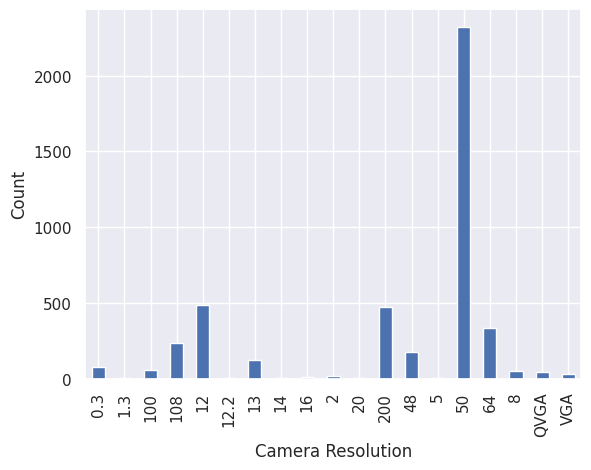

In [36]:
sns.set_theme()
df.groupby('Camera Resolution').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [37]:
def get_resolution(x):
    if x == "QVGA":
        return 320*240*1e-6
    elif x == "VGA":
        return 640*480*1e-6
    else:
        return x

In [38]:
target_cols = ['Camera Resolution']
for col in target_cols:
    df.loc[:, col] = df[col].apply(get_resolution)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Camera Resolution
0,108.0000
1,108.0000
2,108.0000
3,108.0000
4,108.0000
...,...
3982,NaN
3983,1.3000
3984,50.0000
3985,0.3072


In [39]:
def get_dimension(x):
    if x == np.nan or type(x) != type(""):
        return [np.nan, np.nan, np.nan]
    
    result = "".join(x.split()[0:-1]).replace('*', '×').replace('X', '×').replace(
        'x', '×').replace('میلی', '').replace('متر', '').split('×')
    for i,dimension in enumerate(result):
        if re.findall('سانتی',dimension):
            result[i] = float(dimension.replace('سانتی',''))*10
    if len(result) == 3:
        return result
    else:
        return [np.nan, np.nan, np.nan]

In [40]:
for s in df['Dimensions'].to_numpy():
    if type(s) == str and len(re.findall("[^ا-یx×X\*0-9۱-۹. ]", s)):
        print(s)

In [41]:
target_cols = ['X Dimension', 'Y Dimension', 'Z Dimension']
for i,col in enumerate(target_cols):
    df.loc[:, col] = df['Dimensions'].apply(lambda x: get_dimension(x)[i]).astype(float)
df[target_cols]

,X Dimension,Y Dimension,Z Dimension
0,8.0,75.6,162.3
1,8.0,75.6,162.3
2,8.0,75.6,162.3
3,8.0,75.6,162.3
4,8.0,75.6,162.3
...,...,...,...
3982,15.0,50.0,100.0
3983,10.0,51.0,160.0
3984,8.3,76.6,169.6
3985,13.8,53.5,120.8


In [42]:
target_cols = ['Number of Sim Cards']
for col in target_cols:
    df.loc[:, col] = df[col].apply(lambda x: (
        PREPROCESSING_MAP[x.split()[0]]) if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Number of Sim Cards
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
3982,2.0
3983,2.0
3984,2.0
3985,2.0


In [43]:
def get_dar(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    
    splited_dar = x.replace(' ','').split(':')
    if len(splited_dar) == 2:
        return round(float(splited_dar[0]) / float(splited_dar[1]), 3)
    else:
        return np.nan

In [44]:
target_cols = ['DAR']
for col in target_cols:
    df.loc[:, col] = df[col].apply(get_dar)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,DAR
0,2.222
1,2.222
2,2.222
3,2.222
4,2.222
...,...
3982,NaN
3983,NaN
3984,NaN
3985,NaN


In [45]:
target_cols = ['X Screen Resolution','Y Screen Resolution']
for i, col in enumerate(target_cols):
    df.loc[:, col] = df['Screen Resolution'].apply(lambda x: (re.sub("[^0-9]"," ",x).strip(' ').split(' ')[-i])
                                                                                    if x is not np.nan else x)
df[target_cols]

,X Screen Resolution,Y Screen Resolution
0,1080,2400
1,1080,2400
2,1080,2400
3,1080,2400
4,1080,2400
...,...,...
3982,NaN,NaN
3983,128,160
3984,720,1650
3985,240,320


In [46]:
def get_numerical(x):
    try:
        result = float(x)
    except:
        result = np.nan
    return result

In [47]:
target_cols = ['X Screen Resolution','Y Screen Resolution']
for i, col in enumerate(target_cols):
    df.loc[:, col] = df[col].apply(get_numerical)
df[target_cols]

,X Screen Resolution,Y Screen Resolution
0,1080.0,2400.0
1,1080.0,2400.0
2,1080.0,2400.0
3,1080.0,2400.0
4,1080.0,2400.0
...,...,...
3982,NaN,NaN
3983,128.0,160.0
3984,720.0,1650.0
3985,240.0,320.0


In [48]:
def get_release_data(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    
    splited_data = x.split()
    if len(splited_data) == 3:
        return splited_data[2] + f"/{PREPROCESSING_MAP[splited_data[1]]}" + f"/{splited_data[0]}"
    else:
        return np.nan

In [49]:
target_cols = ['Release Data']
for col in target_cols:
    df.loc[:, col] = df[col].apply(get_release_data)
df[target_cols]

,Release Data
0,2024/1/15
1,2024/1/15
2,2024/1/15
3,2024/1/15
4,2024/1/15
...,...
3982,NaN
3983,NaN
3984,2022/3/21
3985,NaN


In [50]:
target_cols = ['Release Data UNIX']
for col in target_cols:
    df.loc[:, col] = df['Release Data'].apply(
        lambda x: time.mktime(datetime.date(int(x.split('/')[0]), int(x.split('/')[1]), int(x.split('/')[2])).timetuple()) 
        if x is not np.nan else x)
df[target_cols]

,Release Data UNIX
0,1.705264e+09
1,1.705264e+09
2,1.705264e+09
3,1.705264e+09
4,1.705264e+09
...,...
3982,NaN
3983,NaN
3984,1.647808e+09
3985,NaN


In [51]:
target_cols = ['Release Data UNIX']
for col in target_cols:
    df.loc[:, col] = df['Release Data'].apply(
        lambda x: time.mktime(datetime.date(
            int(x.split('/')[0]), int(x.split('/')[1]), int(x.split('/')[2])).timetuple())
        if x is not np.nan else x)
df[target_cols]

,Release Data UNIX
0,1.705264e+09
1,1.705264e+09
2,1.705264e+09
3,1.705264e+09
4,1.705264e+09
...,...
3982,NaN
3983,NaN
3984,1.647808e+09
3985,NaN


In [52]:
def get_duration_in_emalls(x):
    if x == np.nan or type(x) != type(""):
        return np.nan, np.nan
    n=0
    duration=0
    if re.findall('سال',x):
        duration+=int(re.sub('[^0-9 ]', '', x).split()[n])
        n+=1
    if re.findall('ماه',x):
        duration += int(re.sub('[^0-9 ]', '', x).split()[n])*12
    return duration

In [53]:
target_cols = ['Duration In Emalls']
for col in target_cols:
    df.loc[:, col] = df['Intime Emalls'].apply(get_duration_in_emalls)
df[target_cols]

,Duration In Emalls
0,131
1,131
2,131
3,131
4,131
...,...
3982,29
3983,29
3984,89
3985,108


In [54]:
def get_warranty(x):
    if x == np.nan or type(x) != type(""):
        return pd.Series((np.nan, np.nan))
    
    splited_warranty = x.split("ماهه")
    if (len(splited_warranty) == 2):
        return pd.Series((splited_warranty[1].split('(')[0].strip(),(splited_warranty[0].split()[-1])))
    else:
        return pd.Series((np.nan,np.nan))

In [55]:
target_cols = ['Warranty', 'Warranty time']
df.loc[:, target_cols] = df["Warranty"].apply(get_warranty).values
df['Warranty time'] = df['Warranty time'].astype(float)
df[target_cols]

,Warranty,Warranty time
0,آرتین تجارت آریا تدبیر,18.0
1,شرکتی,18.0
2,ستاره سپهر فناوری,18.0
3,سیب طلایی هوشمند,18.0
4,پایدار پردازش کوشان,18.0
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,NaN,NaN
3985,NaN,NaN


In [56]:
def get_brand_info(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    return pd.Series(BRAND_INFO[x])

In [57]:
target_cols = ['Brand','Brand Founded Year','Brand Country']
df.loc[:, target_cols] = df["Brand"].apply(get_brand_info).values
df[target_cols]

,Brand,Brand Founded Year,Brand Country
0,Xiaomi,2010,China
1,Xiaomi,2010,China
2,Xiaomi,2010,China
3,Xiaomi,2010,China
4,Xiaomi,2010,China
...,...,...,...
3982,KGTEL,2003,China
3983,KGTEL,2003,China
3984,Xiaomi,2010,China
3985,General Luxe,2007,Iran


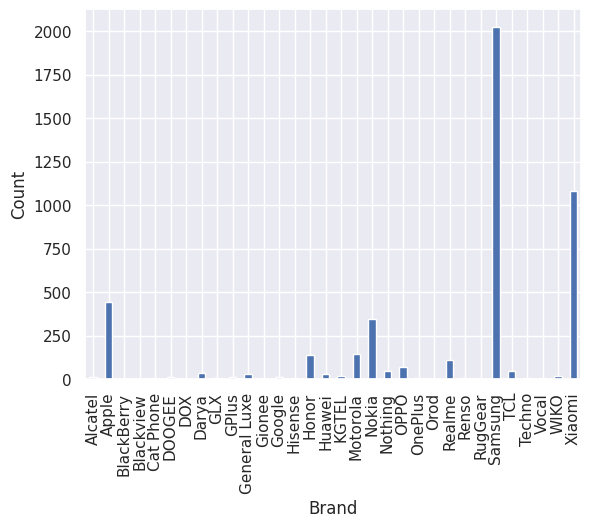

In [58]:
sns.set_theme()
df.groupby('Brand').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [59]:
brand_num = dict()
unique_values = df['Brand'].unique()
for i, brand in enumerate(unique_values):
    brand_num[brand] = i
print(brand_num)

target_cols = ['Brand Num']
print_colls = ['Brand Num', 'Brand']
for col in target_cols:
    df.loc[:, col] = df["Brand"].apply(lambda x: brand_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'Xiaomi': 0, 'Apple': 1, 'Samsung': 2, 'Nokia': 3, 'Renso': 4, 'Alcatel': 5, 'DOX': 6, 'Honor': 7, 'Vocal': 8, 'GPlus': 9, 'General Luxe': 10, 'Motorola': 11, 'TCL': 12, 'Realme': 13, 'OnePlus': 14, 'GLX': 15, 'Gionee': 16, 'Nothing': 17, 'Darya': 18, 'OPPO': 19, 'WIKO': 20, 'Huawei': 21, 'DOOGEE': 22, 'BlackBerry': 23, 'KGTEL': 24, 'Techno': 25, 'Blackview': 26, 'Google': 27, 'Orod': 28, 'RugGear': 29, 'Cat Phone': 30, 'Hisense': 31}


,Brand Num,Brand
0,0.0,Xiaomi
1,0.0,Xiaomi
2,0.0,Xiaomi
3,0.0,Xiaomi
4,0.0,Xiaomi
...,...,...
3982,24.0,KGTEL
3983,24.0,KGTEL
3984,0.0,Xiaomi
3985,10.0,General Luxe


In [60]:
CPU_num = dict()
unique_values = df['CPU'].unique()
for i, CPU in enumerate(unique_values):
    CPU_num[CPU] = i
print(CPU_num)

target_cols = ['CPU Num']
print_colls = ['CPU Num', 'CPU']
for col in target_cols:
    df.loc[:, col] = df["CPU"].apply(lambda x: CPU_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GHz Cortex-A53)': 0, '2x GHz Avalanche + 4x GHz Blizzard': 1, '2x Cortex-A76 + 6x Cortex-A55': 2, nan: 3, '4x Kryo 265 Gold + 4x Kryo 265 Silver': 4, '1x Cortex-X2 + 3x Cortex-A710 + 4x Cortex-A510': 5, '2x Cortex-A75 + 6x Cortex-A55': 6, 'Octa-core (4x2.4 GHz Cortex-A78 &amp; 4x2.0 GHz Cortex-A55)': 7, '4x Cortex-A78 + 4x Cortex-A55': 8, 'Octa-core 3.35 GHz (1+3+4 cores)': 9, '8x Cortex-A53': 10, '4x Cortex-A53 + 4x Cortex-A53': 11, 'Octa-core(CortexTM A55 processor, up to 1.6GHz)': 12, '4xCortex-A53 + 4xCortex-A53': 13, '2x Cortex-A78 + 6x Cortex-A55': 14, 'Octa-core (4x2.75 GHz Cortex-A78 &amp; 4x2.0 GHz Cortex-A55)': 15, '1x Cortex-X4 + 3x Cortex-A720 + 2x Cortex-A720 + 2x Cortex-A520': 16, 'Octa-core (2x2.2 GHz Cortex-A76 &amp; 6x2.0 GHz Cortex-A55)': 17, 'Octa-core (4x2.4 GHz Kryo 265 Gold &amp; 4x1.9 GHz Kryo 265 Silver)': 18, 'Quad-core Cortex-A53': 19, '4x2.2 GHz Cortex-A78 &amp; 4x1.8 GHz Cortex-A55': 20, 'Octa-core (2x1.6 GHz Cor

,CPU Num,CPU
0,0.0,Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GH...
1,0.0,Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GH...
2,0.0,Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GH...
3,0.0,Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GH...
4,0.0,Octa-core (4x2.8 GHz Cortex-A73 &amp; 4x1.9 GH...
...,...,...
3982,80.0,single core
3983,NaN,NaN
3984,4.0,4x Kryo 265 Gold + 4x Kryo 265 Silver
3985,NaN,NaN


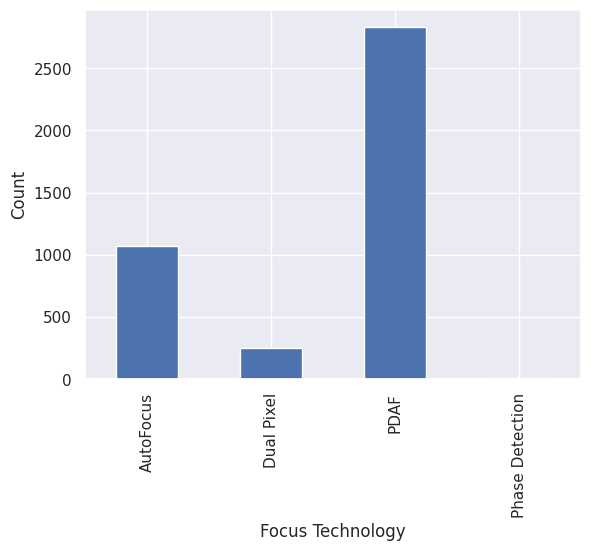

In [61]:
df.groupby('Focus Technology').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [62]:
Focus_Technology_num = dict()
unique_values = df['Focus Technology'].unique()
for i, Focus in enumerate(unique_values):
    Focus_Technology_num[Focus] = i
print(Focus_Technology_num)

target_cols = ['Focus Technology Num']
print_colls = ['Focus Technology Num', 'Focus Technology']
for col in target_cols:
    df.loc[:, col] = df["Focus Technology"].apply(lambda x: Focus_Technology_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'PDAF': 0, 'AutoFocus': 1, nan: 2, 'Dual Pixel': 3, 'Phase Detection': 4}


,Focus Technology Num,Focus Technology
0,0.0,PDAF
1,0.0,PDAF
2,0.0,PDAF
3,0.0,PDAF
4,0.0,PDAF
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,NaN,NaN
3985,NaN,NaN


In [63]:
def get_with_none_persian(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    return x if not re.findall('[ا-ی]',x) else "None"

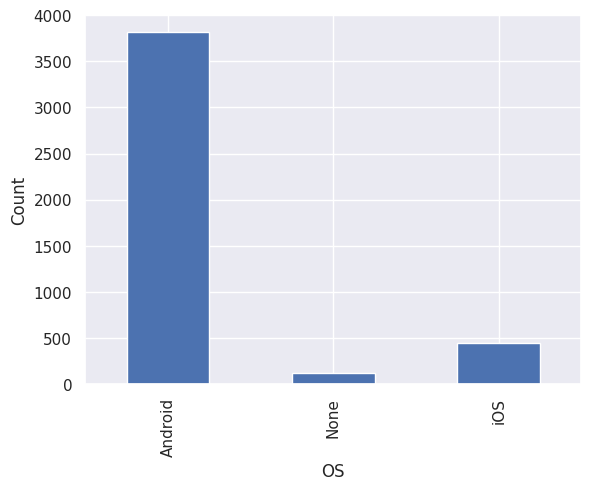

In [64]:
df.loc[:, "OS"] = df['OS'].apply(get_with_none_persian)
df.groupby('OS').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [65]:
OS_num = dict()
unique_values = df['OS'].unique()
for i, OS in enumerate(unique_values):
    OS_num[OS] = i
print(OS_num)

target_cols = ['OS Num']
print_colls = ['OS Num', 'OS']
for col in target_cols:
    df.loc[:, col] = df["OS"].apply(lambda x: OS_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'Android': 0, 'iOS': 1, nan: 2, 'None': 3}


,OS Num,OS
0,0.0,Android
1,0.0,Android
2,0.0,Android
3,0.0,Android
4,0.0,Android
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,0.0,Android
3985,NaN,NaN


In [66]:
GPU_num = dict()
unique_values = df['GPU'].unique()
for i, GPU in enumerate(unique_values):
    GPU_num[GPU] = i
print(GPU_num)

target_cols = ['GPU Num']
print_colls = ['GPU Num', 'GPU']
for col in target_cols:
    df.loc[:, col] = df["GPU"].apply(lambda x: GPU_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'Adreno 610': 0, 'Apple GPU 4-core graphics': 1, 'Mali-G57 MC2 GPU': 2, nan: 3, 'Adreno 610 GPU': 4, 'Xclipse 920 GPU': 5, 'Mali-G52 MC2 GPU': 6, 'Mali-G68 MP5': 7, 'Mali-G68 MP5 GPU': 8, 'Mali G615-MC6': 9, 'MG PowerVR GE8320 GPU': 10, 'PowerVR GE8320 GPU': 11, 'IMG GE8322': 12, 'IMG PowerVR GE8320 GPU': 13, 'Mali-G68 MC4 GPU': 14, 'Adreno 750 GPU': 15, 'Mali-G57 MC2': 16, 'Mali-G68 Chipset': 17, 'Adreno 710 GPU': 18, 'Mali-G57 MP1 GPU': 19, 'Mali-G76 MC4 GPU': 20, 'Mali-G52 MC2': 21, 'Adreno 710': 22, 'Mali-G57 MP1': 23, 'Mali-G57 GPU': 24, 'Adreno 619 GPU': 25, 'IMG BXM-8-256 GPU': 26, 'Adreno 505': 27, 'Mali-G52 GPU': 28, 'Adreno 642L GPU': 29, 'Apple GPU (4-core graphics)': 30, 'Mali-G57': 31, 'PowerVR GE8320': 32, 'Mali-G77 MC9 GPU': 33, 'Mali-G57 MC3 GPU': 34, 'Mali-G610 MC3 GPU': 35, 'Adreno 740 GPU': 36, 'Apple GPU (5-core graphics) GPU': 37, 'Mali-G610 MC6 GPU': 38, 'Apple GPU (4-core graphics) GPU': 39, 'PowerVR GE8300 GPU': 40, 'Adreno 644 GPU': 41, 'Mali-G51 MP4 GPU': 42,

,GPU Num,GPU
0,0.0,Adreno 610
1,0.0,Adreno 610
2,0.0,Adreno 610
3,0.0,Adreno 610
4,0.0,Adreno 610
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,4.0,Adreno 610 GPU
3985,NaN,NaN


In [67]:
def get_cpu_rate(x):
    if x == np.nan or type(x) != type(""):
        return [np.nan, np.nan]
    
    num_list = []
    splited_rate = x.split()
    for rate in splited_rate:
        try:
            num_rate = float(rate)
            num_list.append(num_rate)
        except:
            continue

    if (len(num_list) == 2):
        if num_list[0] > num_list[1]:
            num_list = [num_list[1], num_list[0]]
        return num_list
    else:
        return [np.nan, np.nan]

In [68]:
target_cols = ['CPU Clock Rate Min', "CPU Clock Rate Max"]
for i, col in enumerate(target_cols):
    df.loc[:, col] = df["CPU Clock Rate"].apply(lambda x: get_cpu_rate(x)[i])
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,CPU Clock Rate Min,CPU Clock Rate Max
0,1.9,2.8
1,1.9,2.8
2,1.9,2.8
3,1.9,2.8
4,1.9,2.8
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,1.9,2.4
3985,NaN,NaN


In [69]:
target_cols = ['Range of Screen Size Min', "Range of Screen Size Max"]
for i, col in enumerate(target_cols):
    df.loc[:, col] = df["Range of Screen Size"].apply(lambda x: get_cpu_rate(x)[i])
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Range of Screen Size Min,Range of Screen Size Max
0,6.0,8.0
1,6.0,8.0
2,6.0,8.0
3,6.0,8.0
4,6.0,8.0
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,6.0,8.0
3985,2.0,2.4


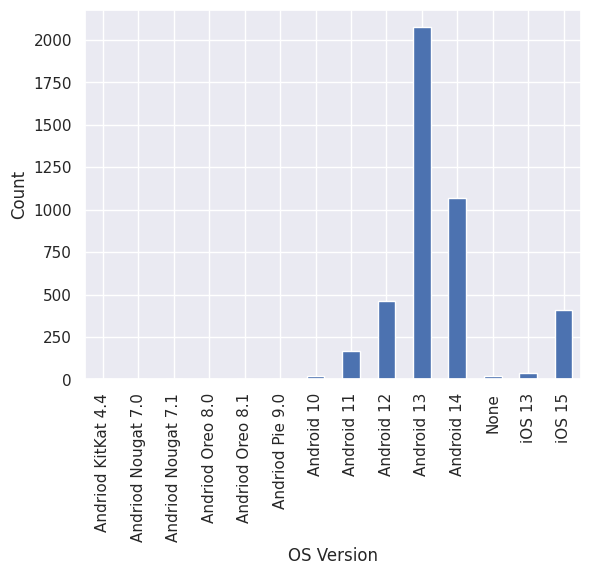

In [70]:
df.loc[:, "OS Version"] = df['OS Version'].apply(get_with_none_persian)
df.groupby('OS Version').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [71]:
OS_Version_num = dict()
unique_values = df['OS Version'].unique()
for i, OS in enumerate(unique_values):
    OS_Version_num[OS] = i
print(OS_Version_num)

target_cols = ['OS Version Num']
print_colls = ['OS Version Num', 'OS Version']
for col in target_cols:
    df.loc[:, col] = df["OS Version"].apply(lambda x: OS_Version_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'Android 13': 0, 'iOS 15': 1, 'Android 14': 2, nan: 3, 'Android 11': 4, 'Android 12': 5, 'Android 10': 6, 'Andriod Nougat 7.1': 7, 'iOS 13': 8, 'None': 9, 'Andriod Oreo 8.1': 10, 'Andriod Oreo 8.0': 11, 'Andriod Nougat 7.0': 12, 'Andriod Pie 9.0': 13, 'Andriod KitKat 4.4': 14}


,OS Version Num,OS Version
0,0.0,Android 13
1,0.0,Android 13
2,0.0,Android 13
3,0.0,Android 13
4,0.0,Android 13
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,4.0,Android 11
3985,NaN,NaN


In [72]:
def get_eng_memory(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    memory_map = {"گیگابایت": "GB", "مگابایت": "MB", "ترابایت": "TB",
                  "یک": "1", "دو": "2", "سه": "3", "چهار": "4", "شش": "6", "هشت": "8"}
    for fa, eng in memory_map.items():
        x = x.replace(fa, eng)
    return x

In [73]:
def get_internal_memory_or_ram(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    
    splited_mem = x.split()
    if splited_mem[0] == "چهار":
        num = 4
    elif splited_mem[0] == "یک": 
        num = 1
    elif splited_mem[0] == "دو": 
        num = 2
    elif splited_mem[0] == "سه": 
        num = 3
    elif splited_mem[0] == "شش": 
        num = 6
    elif splited_mem[0] == "هشت": 
        num = 8
    else:
        num = int(splited_mem[0])

    if splited_mem[1] == "مگابایت":
        power = 1 
    elif splited_mem[1] == "گیگابایت":
        power = 3
    elif splited_mem[1] == "ترابایت":
        power = 6
    else:
        return np.nan
    
    return float(num * (10**power))

In [74]:
target_cols = ['Internal Memory Num']
for i, col in enumerate(target_cols):
    df.loc[:, col] = df["Internal Memory"].apply(get_internal_memory_or_ram)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Internal Memory Num
0,256000.0
1,256000.0
2,256000.0
3,256000.0
4,256000.0
...,...
3982,320.0
3983,280.0
3984,64000.0
3985,40.0


In [75]:
target_cols = ['RAM Num']
for i, col in enumerate(target_cols):
    df.loc[:, col] = df["RAM"].apply(get_internal_memory_or_ram)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,RAM Num
0,8000.0
1,8000.0
2,8000.0
3,8000.0
4,8000.0
...,...
3982,320.0
3983,NaN
3984,3000.0
3985,160.0


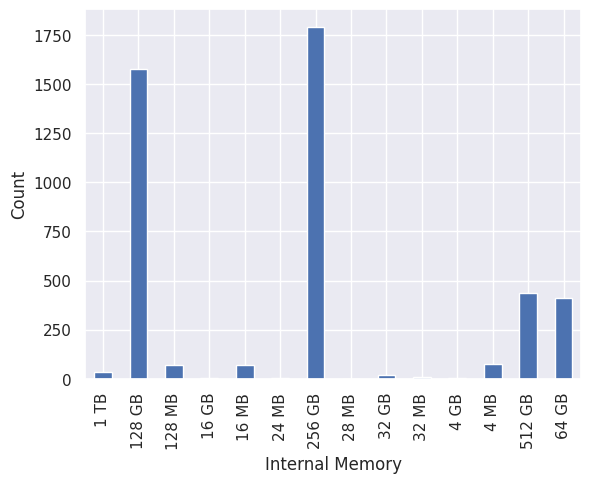

In [76]:
df.loc[:,'Internal Memory']=df['Internal Memory'].apply(get_eng_memory)
df.groupby('Internal Memory').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

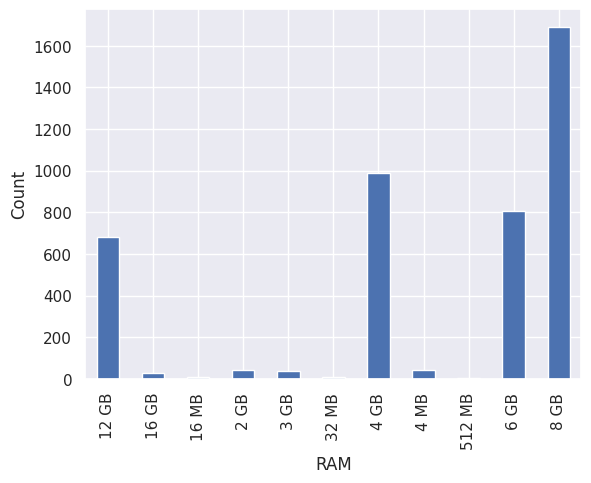

In [77]:
df['RAM'] = df['RAM'].apply(get_eng_memory)
df.groupby('RAM').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

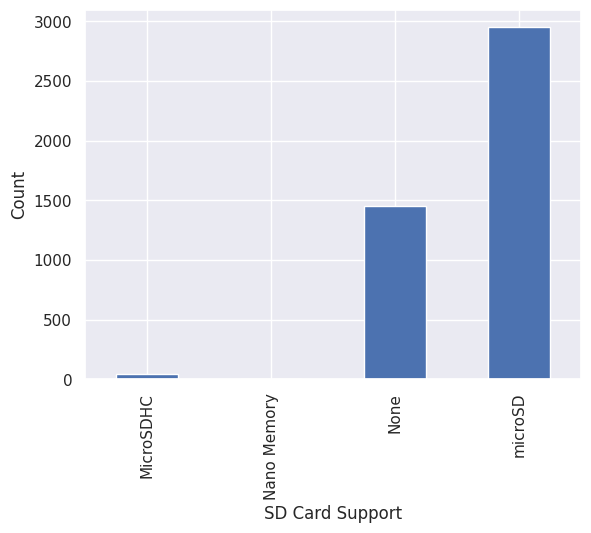

In [78]:
df.loc[:, 'SD Card Support'] = df['SD Card Support'].apply(get_with_none_persian)
df.groupby('SD Card Support').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [79]:
def get_SD_Card_Support(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    
    x = x.split()[0]
    if x == "microSD" or x == "MicroSDHC":
        return 1
    else:
        return 0

In [80]:
target_cols = ['SD Card Support Num']
for i, col in enumerate(target_cols):
    df.loc[:, col] = df["SD Card Support"].apply(get_SD_Card_Support)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,SD Card Support Num
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
3982,NaN
3983,1.0
3984,1.0
3985,NaN


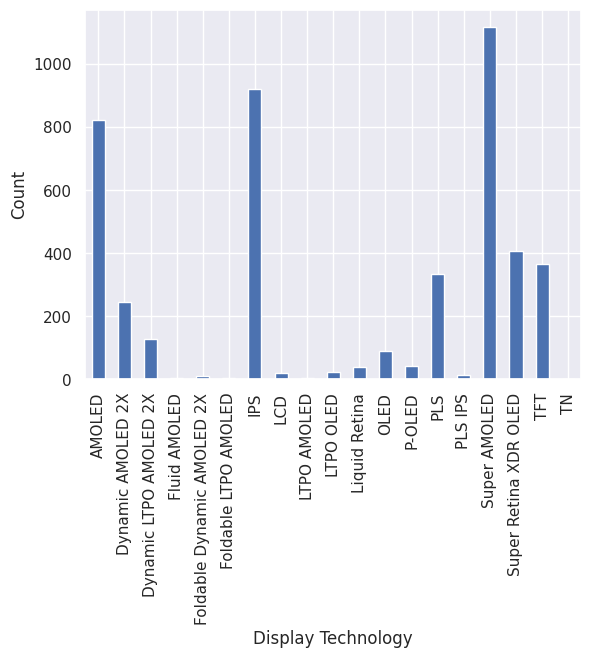

In [81]:
df.groupby('Display Technology').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [82]:
Display_Technology_num = dict()
unique_values = df['Display Technology'].unique()
for i, Display in enumerate(unique_values):
    Display_Technology_num[Display] = i
print(Display_Technology_num)

target_cols = ['Display Technology Num']
print_colls = ['Display Technology Num', 'Display Technology']
for col in target_cols:
    df.loc[:, col] = df["Display Technology"].apply(lambda x: Display_Technology_num[x] if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[print_colls]

{'AMOLED': 0, 'Super Retina XDR OLED': 1, 'Super AMOLED': 2, 'TFT': 3, 'PLS': 4, 'Dynamic AMOLED 2X': 5, 'IPS': 6, nan: 7, 'TN': 8, 'LCD': 9, 'Dynamic LTPO AMOLED 2X': 10, 'P-OLED': 11, 'PLS IPS': 12, 'OLED': 13, 'Liquid Retina': 14, 'LTPO OLED': 15, 'Foldable LTPO AMOLED': 16, 'LTPO AMOLED': 17, 'Fluid AMOLED': 18, 'Foldable Dynamic AMOLED 2X': 19}


,Display Technology Num,Display Technology
0,0.0,AMOLED
1,0.0,AMOLED
2,0.0,AMOLED
3,0.0,AMOLED
4,0.0,AMOLED
...,...,...
3982,NaN,NaN
3983,NaN,NaN
3984,6.0,IPS
3985,NaN,NaN


In [83]:
target_cols = ['Screen Size']
for col in target_cols:
    df.loc[:, col] = df['Screen Size'].apply(lambda x: float(x.split()[0]) if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Screen Size
0,6.67
1,6.67
2,6.67
3,6.67
4,6.67
...,...
3982,1.80
3983,1.80
3984,6.71
3985,2.40


In [84]:
target_cols = ['Pixel Density']
for col in target_cols:
    df.loc[:, col] = df['Pixel Density'].apply(lambda x: float(x.split()[0]) if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Pixel Density
0,395.0
1,395.0
2,395.0
3,395.0
4,395.0
...,...
3982,NaN
3983,NaN
3984,268.0
3985,NaN


In [85]:
target_cols = ['Ratio of Screen Size to Body']
for col in target_cols:
    df.loc[:, col] = df['Ratio of Screen Size to Body'].apply(lambda x: float(x.split()[0].split('%')[0]) if x is not np.nan else x)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Ratio of Screen Size to Body
0,87.5
1,87.5
2,87.5
3,87.5
4,87.5
...,...
3982,NaN
3983,NaN
3984,82.0
3985,NaN


In [86]:
def get_dict_of_uniques(df_col):
    all_colors=set()
    for colors in df_col.values:
        all_colors.update(
            eval(colors if not pd.isna(colors) and not pd.isnull(colors) else "[]"))
    return {color: i for i, color in enumerate(all_colors)}

In [87]:
def get_one_hot_encoded_df(x, all_uniques_dict):
    if pd.isna(x) or pd.isnull(x):
        return pd.Series([np.nan]*len(all_uniques_dict))
    uniques = [0]*len(all_uniques_dict)
    x_uniques=eval(x)
    for unique in x_uniques:
        uniques[all_uniques_dict[unique]] = 1
    return pd.Series(uniques)

In [88]:
all_colors_dict = get_dict_of_uniques(df['Available Colors'])
target_cols = all_colors_dict.keys()
df.loc[:, target_cols] = df["Available Colors"].apply(
    get_one_hot_encoded_df, all_uniques_dict=all_colors_dict).values
df[target_cols]

,مشکی,آبی تیره,آبی یخی,صورتی,سبز,سبز روشن,آبی,زرد لیمویی,ذغالی,کرم,...,ارغوانی,سبز دریایی,آبی روشن,سفید صدفی,بنفش,سرمه ای,زیتونی,یاسی,نقره ای,سبز تیره
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df.loc[:, 'Number of Availabler Colors'] = df[all_colors_dict.keys()].sum(axis=1,min_count=1)

{'قرمز': 0, 'کرم': 1, 'سفید': 2, 'سرمه ای روشن': 3, 'سبز دریایی': 4, 'آبی': 5, 'نارنجی': 6, 'سبز روشن': 7, 'بنفش': 8, 'طلایی': 9, 'آبی یخی': 10, 'سرمه ای': 11, 'زیتونی': 12, 'زرد': 13, 'قهوه ای': 14, 'سفید صدفی': 15, 'نقره ای': 16, 'برنز': 17, 'فیروزه ای': 18, 'مسی': 19, 'آبی روشن': 20, 'سبز تیره': 21, 'زرد لیمویی': 22, 'ذغالی': 23, 'خاکستری': 24, 'ارغوانی': 25, 'سرخابی': 26, 'آبی نیلی': 27, 'سبز': 28, 'صورتی': 29, 'مشکی': 30, 'یاسی': 31, 'آبی تیره': 32, 'آبی نفتی': 33, 'قرمز تیره': 34}

{'مشکی': 0, 'آبی تیره': 1, 'آبی یخی': 2, 'صورتی': 3, 'سبز': 4, 'سبز روشن': 5, 'آبی': 6, 'زرد لیمویی': 7, 'ذغالی': 8, 'کرم': 9, 'سرمه ای روشن': 10, 'آبی نفتی': 11, 'مسی': 12, 'سرخابی': 13, 'زرد': 14, 'طلایی': 15, 'نارنجی': 16, 'قرمز تیره': 17, 'سفید': 18, 'فیروزه ای': 19, 'برنز': 20, 'قهوه ای': 21, 'قرمز': 22, 'آبی نیلی': 23, 'خاکستری': 24, 'ارغوانی': 25, 'سبز دریایی': 26, 'آبی روشن': 27, 'سفید صدفی': 28, 'بنفش': 29, 'سرمه ای': 30, 'زیتونی': 31, 'یاسی': 32, 'نقره ای': 33, 'سبز تیره': 34}


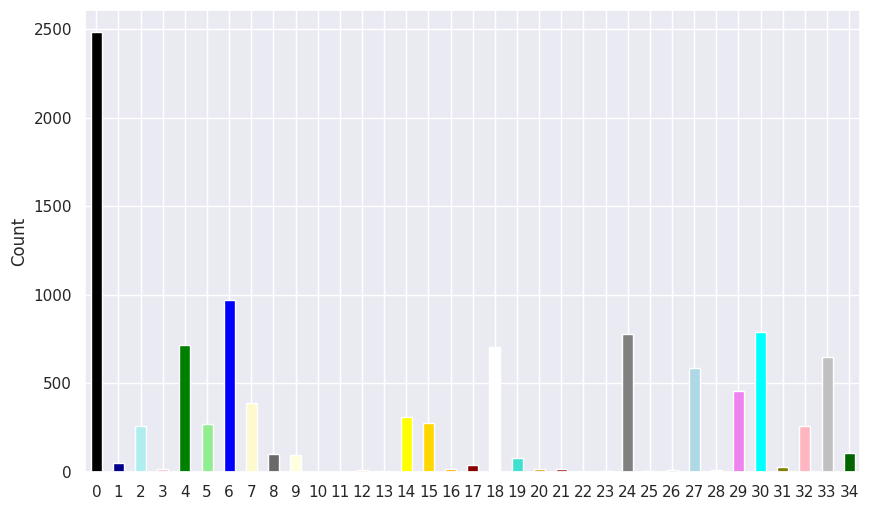

In [90]:
plt_colors_map={'قرمز':'red','کرم': 'lightyellow','سفید': 'white','سرمه ای روشن': 'dodgerblue','سبز دریایی': 'seagreen','آبی': 'blue',
            'نارنجی': 'orange','سبز روشن': 'lightgreen','ذغالی':'dimgray','خاکستری': 'gray','سفید صدفی': 'seashell','نقره ای': 'silver', 
            'بنفش':'violet','طلایی': 'gold','آبی یخی': 'paleturquoise','سرمه ای': 'cyan','زیتونی': 'olive','زرد': 'yellow','قهوه ای': 'brown',
            'برنز':'goldenrod','فیروزه ای': 'Turquoise','مسی': 'peru','آبی روشن':'lightblue','سبز تیره':'darkgreen','زرد لیمویی':'lemonchiffon',
            'ارغوانی': 'purple','سرخابی':'magenta','آبی نیلی':'azure','سبز':'green','صورتی':'pink','مشکی':'black','یاسی':'lightpink','آبی تیره':'darkblue',
            'آبی نفتی':'teal','قرمز تیره':'darkred'}
plt_colors=[plt_colors_map[color] for color in all_colors_dict.keys()]
df[all_colors_dict.keys()].sum().plot(
    kind='bar', rot=0, figsize=(10, 6), color=plt_colors,xticks=np.arange(len(all_colors_dict)))
print(all_colors_dict)
plt.ylabel('Count')
plt.show()

In [91]:
target_cols = ['Score']
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Score
0,4.4
1,4.4
2,4.4
3,4.4
4,4.4
...,...
3982,3.7
3983,3.0
3984,4.3
3985,4.3


In [92]:
def get_Back_Cameras(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    x = x.split()[0]
    if x == "بدون":
        return 0
    else:
        return float(x)

In [93]:
target_cols = ['Back Facing Cameras']
for col in target_cols:
    df.loc[:, col] = df['Back Facing Cameras'].apply(get_Back_Cameras)
df[target_cols] = df[target_cols].astype(float)
df[target_cols]

,Back Facing Cameras
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
3982,1.0
3983,1.0
3984,2.0
3985,1.0


In [94]:
df['Cellular Network'].unique()

array(['2G 3G 4G', '2G 3G 4G 5G', '2G', nan, '2G 3G', '4G'], dtype=object)

In [95]:
df['Cellular Network'] = df['Cellular Network'].map(
    {'2G': 2, '2G 3G': 3, '4G': 4, '2G 3G 4G': 4, '2G 3G 4G 5G':5}, na_action='ignore')
df[target_cols]

,Back Facing Cameras
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
3982,1.0
3983,1.0
3984,2.0
3985,1.0


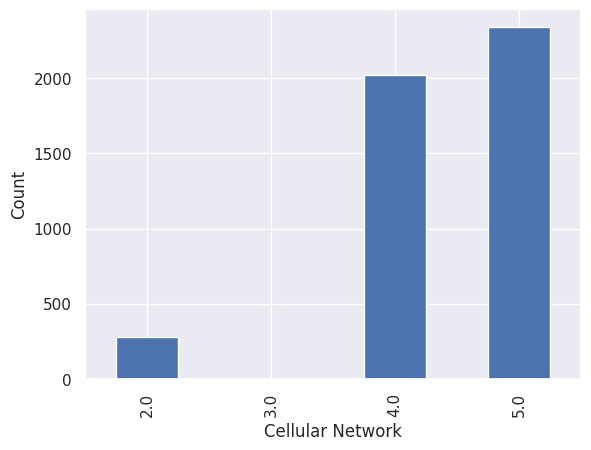

In [96]:
df.groupby('Cellular Network').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4657 entries, 0 to 3986
Columns: 120 entries, Model to Number of Availabler Colors
dtypes: float64(68), int64(2), object(50)
memory usage: 4.3+ MB


In [98]:
df.select_dtypes(exclude=[np.number, bool]).columns

Index(['Model', 'Release Data', 'Dimensions', 'Brand', 'Seller',
       'Sim Card Description', 'Sim Card Type', 'Body Structure',
       'Key Features', 'CPU', 'CPU Clock Rate', 'GPU', 'SD Card Description',
       'Range of Screen Size', 'Other Screen Features', 'GPS', 'Wi-Fi Type',
       'Bluetooth', 'Ports', 'Focus Technology', 'Flashlight',
       'Camera Features', 'Video Recording', 'Audio Output', 'OS',
       'OS Version', 'Sensors', 'Battery Spec', 'Accessories',
       'Accessories Description', 'Category', 'Chipset', 'Internal Memory',
       'RAM', 'Warranty', 'SD Card Support', 'Display Technology',
       'Screen Resolution', 'Supplementary Audio Description',
       'Supported Networks', 'Front Facing Cameras', 'Available Colors',
       'Special Features', 'City', 'Is Special Emalls', 'Intime Emalls',
       'Installment', 'X Screen Resolution', 'Y Screen Resolution',
       'Brand Country'],
      dtype='object')

In [99]:
df.select_dtypes(include=[np.number, bool]).columns

Index(['Weight', 'DAR', 'Bluetooth Version', 'Camera Resolution',
       'Price Final', 'Screen Size', 'Pixel Density',
       'Ratio of Screen Size to Body', 'Cellular Network',
       'Back Facing Cameras', 'Price No Discount', 'Number of Sim Cards',
       'Score', 'X Dimension', 'Y Dimension', 'Z Dimension',
       'Release Data UNIX', 'Duration In Emalls', 'Warranty time',
       'Brand Founded Year', 'Brand Num', 'CPU Num', 'Focus Technology Num',
       'OS Num', 'GPU Num', 'CPU Clock Rate Min', 'CPU Clock Rate Max',
       'Range of Screen Size Min', 'Range of Screen Size Max',
       'OS Version Num', 'Internal Memory Num', 'RAM Num',
       'SD Card Support Num', 'Display Technology Num', 'مشکی', 'آبی تیره',
       'آبی یخی', 'صورتی', 'سبز', 'سبز روشن', 'آبی', 'زرد لیمویی', 'ذغالی',
       'کرم', 'سرمه ای روشن', 'آبی نفتی', 'مسی', 'سرخابی', 'زرد', 'طلایی',
       'نارنجی', 'قرمز تیره', 'سفید', 'فیروزه ای', 'برنز', 'قهوه ای', 'قرمز',
       'آبی نیلی', 'خاکستری', 'ارغوانی', 'س

In [100]:
df['Is Special Emalls'] = df['Is Special Emalls'].astype(bool)
df['Installment'] = df['Installment'].astype(bool)
df['Y Screen Resolution'] = df['Y Screen Resolution'].astype(float)
df['X Screen Resolution'] = df['X Screen Resolution'].astype(float)

In [101]:
numerical_cols = df.select_dtypes(include=[np.number, bool])
corr_matrix = numerical_cols.corr().abs()
corr_matrix[corr_matrix<1].unstack().sort_values(kind="quicksort", ascending=False).head(60)

Range of Screen Size Max      Range of Screen Size Min        0.998083
Range of Screen Size Min      Range of Screen Size Max        0.998083
Price No Discount             Price Final                     0.992457
Price Final                   Price No Discount               0.992457
DAR                           Range of Screen Size Max        0.987124
Range of Screen Size Max      DAR                             0.987124
DAR                           Screen Size                     0.986597
Screen Size                   DAR                             0.986597
Range of Screen Size Min      DAR                             0.985790
DAR                           Range of Screen Size Min        0.985790
Screen Size                   Range of Screen Size Min        0.980208
Range of Screen Size Min      Screen Size                     0.980208
Range of Screen Size Max      Screen Size                     0.979985
Screen Size                   Range of Screen Size Max        0.979985
آبی یخ

In [102]:
numerical_cols = df.select_dtypes(include=[np.number])
corr_matrix = numerical_cols.corr().abs().loc[:, ['Price Final']]
corr_matrix[corr_matrix < 1].unstack().sort_values(kind="quicksort", ascending=False).head(60)

Price Final  Price No Discount               0.992457
             CPU Clock Rate Max              0.211343
             SD Card Support Num             0.179682
             X Screen Resolution             0.172155
             Pixel Density                   0.156716
             Cellular Network                0.141013
             CPU Num                         0.135616
             Release Data UNIX               0.128579
             Weight                          0.127516
             Internal Memory Num             0.125244
             GPU Num                         0.125116
             Focus Technology Num            0.120588
             طلایی                           0.115345
             X Dimension                     0.111999
             Z Dimension                     0.104424
             سبز                             0.099837
             Back Facing Cameras             0.098337
             خاکستری                         0.088075
             نقره ای        

In [112]:
numerical_cols = df.select_dtypes(include=[np.number])
corr_matrix = numerical_cols.corr().abs().loc[:, ['Price No Discount']]
corr_matrix[corr_matrix < 1].unstack().sort_values(
    kind="quicksort", ascending=False).head(60)

Price No Discount  Price Final                     0.992457
                   CPU Clock Rate Max              0.177467
                   SD Card Support Num             0.155112
                   X Screen Resolution             0.142936
                   Pixel Density                   0.134906
                   Cellular Network                0.123790
                   CPU Num                         0.119735
                   GPU Num                         0.110744
                   Release Data UNIX               0.110484
                   Weight                          0.108863
                   Internal Memory Num             0.107333
                   X Dimension                     0.095796
                   طلایی                           0.095459
                   Focus Technology Num            0.094035
                   Z Dimension                     0.089008
                   سبز                             0.086937
                   نقره ای              

In [113]:
df.groupby('SD Card Support Num')['Price No Discount'].mean()

SD Card Support Num
0.0    4.002190e+08
1.0    1.195686e+08
Name: Price No Discount, dtype: float64

In [122]:
stats.ttest_ind(df[df['SD Card Support Num'] == 0]['Price Final'], df[df['SD Card Support Num']
                == 1]['Price Final'], equal_var=True, nan_policy='raise', alternative='greater')

TtestResult(statistic=12.183230649040835, pvalue=6.515753922132452e-34, df=4449.0)

In [121]:
stats.ttest_ind(df[df['SD Card Support Num'] == 0]['Price No Discount'], df[df['SD Card Support Num'] 
                    == 1]['Price No Discount'], equal_var=True,nan_policy='raise',alternative='greater')

TtestResult(statistic=10.472868714865047, pvalue=1.1328072598369253e-25, df=4449.0)

In [126]:
df.groupby('طلایی')['Price No Discount'].mean()

طلایی
0.0    1.918271e+08
1.0    5.295624e+08
Name: Price No Discount, dtype: float64

In [173]:
stats.ttest_ind(df[df['طلایی'] == 1]['Price Final'], df[df['طلایی']
                == 0]['Price Final'], equal_var=True, nan_policy='raise', alternative='greater')

TtestResult(statistic=7.823274556444319, pvalue=3.1782513690217577e-15, df=4539.0)

In [174]:
stats.ttest_ind(df[df['طلایی'] == 1]['Price No Discount'], df[df['طلایی']
                    == 0]['Price No Discount'], equal_var=True, nan_policy='raise',alternative='greater')

TtestResult(statistic=6.460802378194367, pvalue=5.754644242307019e-11, df=4539.0)

In [170]:
df.groupby('DAR')['Price No Discount'].mean()

DAR
1.333    1.537896e+07
1.778    2.724550e+07
2.000    1.569588e+07
2.167    2.353424e+08
2.222    1.811321e+08
Name: Price No Discount, dtype: float64

In [176]:
stats.ttest_ind(df[df['DAR'] == 1.333]['Price Final'], df[df['DAR']
                == 1.778]['Price Final'], equal_var=True, nan_policy='raise', alternative='less')

TtestResult(statistic=-0.7648283142587583, pvalue=0.2225233620579889, df=268.0)

In [178]:
stats.ttest_ind(df[df['DAR'] == 1.333]['Price No Discount'], df[df['DAR']
                == 1.778]['Price No Discount'], equal_var=True, nan_policy='raise', alternative='less')

TtestResult(statistic=-1.1797470641940124, pvalue=0.11957349373481167, df=268.0)

In [182]:
df.groupby('Score')['Price No Discount'].count()

Score
1.0       2
1.4       3
1.6       6
2.0       8
2.8       2
3.0     129
3.1       1
3.2      47
3.3       2
3.4       2
3.5      29
3.6      23
3.7      36
3.8      30
3.9     134
4.0     276
4.1     363
4.2     487
4.3     783
4.4    1272
4.5     555
4.6     117
4.7     105
4.8      50
5.0      27
Name: Price No Discount, dtype: int64

In [184]:
stats.ttest_ind(df[df['Score'] == 4.0]['Price Final'], df[df['Score']
                == 3.0]['Price Final'], equal_var=True, nan_policy='raise', alternative='less')

TtestResult(statistic=-5.279047498770833, pvalue=1.063685214089899e-07, df=403.0)

In [185]:
stats.ttest_ind(df[df['Score'] == 4.0]['Price No Discount'], df[df['Score']
                == 3.0]['Price No Discount'], equal_var=True, nan_policy='raise', alternative='less')

TtestResult(statistic=-4.252996526823244, pvalue=1.3123450836615024e-05, df=403.0)

In [103]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_data_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': missing_percentage})
missing_data_df.sort_values('Percentage Missing',ascending=False).head(60)

,Missing Values,Percentage Missing
Sim Card Type,4657,100.000000
Warranty,3518,75.542195
Warranty time,3518,75.542195
Supplementary Audio Description,3424,73.523728
SD Card Description,2294,49.259180
Body Structure,1602,34.399828
CPU Clock Rate Min,1421,30.513206
CPU Clock Rate Max,1421,30.513206
Key Features,1074,23.062057
Other Screen Features,812,17.436118


In [104]:
missing_data_df.sort_values('Percentage Missing', ascending=True).head(30)

,Missing Values,Percentage Missing
Installment,0,0.000000
Brand Founded Year,0,0.000000
Intime Emalls,0,0.000000
Is Special Emalls,0,0.000000
City,0,0.000000
Brand Country,0,0.000000
Price No Discount,0,0.000000
Brand Num,0,0.000000
Back Facing Cameras,0,0.000000
Price Final,0,0.000000
